In [1]:
import numpy as np
import pandas as pd
import os
import time
from gensim.parsing.preprocessing import remove_stopwords
from gensim import models
from pathlib import Path
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from string import digits

2022-06-27 17:22:10.612277: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
# loading datasets and preliminary cleaning

subtitles=pd.read_csv('../../data/movies_subtitles.csv')
metas=pd.read_csv('../../data/meta_rotten.csv')

indexes=list(metas['imdb_id'])
subtitles=subtitles.loc[subtitles['imdb_id'].isin(indexes)] # remove all movies that are not in imdb dataset
print("{} subtitles from {} movies".format(len(subtitles), len(indexes)))

5589021 subtitles from 2553 movies


In [3]:
print(metas[['tomatometer_status', 'tomatometer_rating',  'audience_rating',  'imdb_id']])

     tomatometer_status  tomatometer_rating  audience_rating    imdb_id
0                 Fresh                96.0             79.0  tt0381849
1       Certified-Fresh                89.0             86.0  tt0381849
2                 Fresh               100.0             86.0  tt0042281
3       Certified-Fresh               100.0             89.0  tt0029843
4                 Fresh                80.0             91.0  tt0112454
...                 ...                 ...              ...        ...
2548    Certified-Fresh                76.0             51.0  tt0406375
2549             Rotten                46.0             51.0  tt2131698
2550             Rotten                55.0             39.0  tt1363468
2551              Fresh                65.0             77.0  tt0120906
2552              Fresh                69.0             31.0  tt2784512

[2553 rows x 4 columns]


(array([ 782.,    0.,    0.,    0.,    0.,  566.,    0.,    0.,    0.,
        1203.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

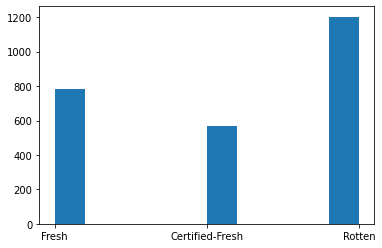

In [4]:
plt.hist(metas['tomatometer_status'].dropna().astype(str))

In [5]:
print(subtitles)

         Unnamed: 0  start_time  end_time  \
0                 0      58.559    61.602   
1                 1      61.687    63.354   
2                 2      64.398    66.482   
3                 3      68.318    71.612   
4                 4      71.697    74.031   
...             ...         ...       ...   
5589016    10342192    7559.164  7566.127   
5589017    10342193    7566.337  7572.606   
5589018    10342194    7581.786  7583.378   
5589019    10342195    7586.458  7589.689   
5589020    10342196    7593.331  7596.129   

                                                      text    imdb_id  
0        BOY: All right, everyone!\nThis... is a stick-up!  tt0114709  
1                                      Don't anybody move!  tt0114709  
2                                    Now, empty that safe!  tt0114709  
3             Ooh-hoo-hoo!\nMoney, money, money! (KISSING)  tt0114709  
4                 Stop it! Stop it,\nyou mean, old potato!  tt0114709  
...                        

In [6]:
print(subtitles.shape)

(5589021, 5)


In [7]:
# clean subtitle's text

def clean_text(x):
    '''
    method to normalize the movie titles
    '''
    x=x.lower()  
        
    for char in ["\n", "-"]:
        x=x.replace(char, " ")  
    if "♪" in x:
        x=""
   # x=remove_stopwords(x)
    return x
 
subtitles=subtitles.dropna()

subtitles['text']=subtitles['text'].apply(clean_text)

In [8]:
print(subtitles.shape)

(5578943, 5)


In [9]:
#create dictionary {movie_id:subtitles}

movies_ids=list(subtitles['imdb_id'].unique())

dictio={}
for i in movies_ids:
    subset=subtitles.loc[subtitles['imdb_id']==i]
    subtitle_str=""
    for j in subset['text']:
        subtitle_str+=j
    dictio[i]=subtitle_str.replace("\'", "'")
    
    
print(dictio[:1])

KeyboardInterrupt: 

In [ ]:
# save subtitles in directory
for i in dictio:
    data=metas[['tomatometer_status', "title"]].loc[metas["imdb_id"]==i].reset_index()

    # save dictio[i] as txt file
    print(data['tomatometer_status'][0])
    #open text file
    text_file = open("../../subtitles_txt/"+str(data['tomatometer_status'][0])+"/"+i+".txt", "w")

    #write string to file
    n = text_file.write(dictio[i])

    #close file
    text_file.close()


In [ ]:
print(len(dictio))

In [ ]:
# divide in train val and test

# train and validation set split for image classification

TRAIN_DATA_FOLDER = "../../subtitles_txt/train/"

files = glob.glob(TRAIN_DATA_FOLDER + "*.txt")
paths = []
labels = []

for file in files:
    label_str = file.split("/")[-2]
    paths.append(file)
    labels.append(label_str)


(trainPaths, domPaths, trainLabels, domLabels) = train_test_split(
    paths, labels, test_size=400, stratify=labels, random_state=42
)

print(domPaths[:5])

DOM_DATA_FOLDER = "../../subtitles_txt/val/"

for domPath, domLabel in zip(domPaths, domLabels):

    if not os.path.isdir(DOM_DATA_FOLDER + domLabel):
        os.mkdir(DOM_DATA_FOLDER + domLabel)

    os.rename(domPath, DOM_DATA_FOLDER + domLabel + "/" + domPath.split("/")[-1])

In [78]:
# code from https://gmihaila.github.io/tutorial_notebooks/gpt2_finetune_classification/

import io
import os
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
#from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW, 
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)

In [79]:
# Set seed for reproducibility.
set_seed(123)

# Number of training epochs (authors on fine-tuning Bert recommend between 2 and 4).
epochs = 4

# Number of batches - depending on the max sequence length and GPU memory.
# For 512 sequence length batch of 10 works without cuda memory issues.
# For small sequence length can try batch of 32 or higher.
batch_size = 32

# Pad or truncate text sequences to a specific length
# if `None` it will use maximum sequence of word piece tokens allowed by model.
max_length = 60


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model_name_or_path = 'gpt2'

# Dictionary of labels and their id - this will be used to convert.
# String labels to number ids.
labels_ids = {'rotten': 0, 'Fresh': 1, 'Certified-Fresh': 2}

# How many labels are we using in training.
# This is used to decide size of classification head.
n_labels = len(labels_ids)

cuda


In [ ]:
class MovieReviewsDataset(Dataset):
    r"""PyTorch Dataset class for loading data.

    This is where the data parsing happens.

    This class is built with reusability in mind: it can be used as is as.

    Arguments:

    path (:obj:`str`):
        Path to the data partition.

    """

    def __init__(self, path, use_tokenizer):

        # Check if path exists.
        if not os.path.isdir(path):
          # Raise error if path is invalid.
          raise ValueError('Invalid `path` variable! Needs to be a directory')
        self.texts = []
        self.labels = []
        # Since the labels are defined by folders with data we loop 
        # through each label.
        for label in ['pos', 'neg']:
            sentiment_path = os.path.join(path, label)

            # Get all files from path.
            files_names = os.listdir(sentiment_path)#[:10] # Sample for debugging.
            # Go through each file and read its content.
            for file_name in tqdm(files_names, desc=f'{label} files'):
            file_path = os.path.join(sentiment_path, file_name)

            # Read content.
            content = io.open(file_path, mode='r', encoding='utf-8').read()
            # Fix any unicode issues.
            content = fix_text(content)
            # Save content.
            self.texts.append(content)
            # Save encode labels.
            self.labels.append(label)

        # Number of exmaples.
        self.n_examples = len(self.labels)


        return

    def __len__(self):
        r"""When used `len` return the number of examples.

        """

        return self.n_examples

    def __getitem__(self, item):
        r"""Given an index return an example from the position.

        Arguments:

          item (:obj:`int`):
              Index position to pick an example to return.

        Returns:
          :obj:`Dict[str, str]`: Dictionary of inputs that contain text and 
          asociated labels.

        """

        return {'text':self.texts[item],
                'label':self.labels[item]}


    class Gpt2ClassificationCollator(object):
        r"""
        Data Collator used for GPT2 in a classification rask. 

        It uses a given tokenizer and label encoder to convert any text and labels to numbers that 
        can go straight into a GPT2 model.

        This class is built with reusability in mind: it can be used as is as long
        as the `dataloader` outputs a batch in dictionary format that can be passed 
        straight into the model - `model(**batch)`.

        Arguments:

          use_tokenizer (:obj:`transformers.tokenization_?`):
              Transformer type tokenizer used to process raw text into numbers.

          labels_ids (:obj:`dict`):
              Dictionary to encode any labels names into numbers. Keys map to 
              labels names and Values map to number associated to those labels.

          max_sequence_len (:obj:`int`, `optional`)
              Value to indicate the maximum desired sequence to truncate or pad text
              sequences. If no value is passed it will used maximum sequence size
              supported by the tokenizer and model.

        """

        def __init__(self, use_tokenizer, labels_encoder, max_sequence_len=None):

            # Tokenizer to be used inside the class.
            self.use_tokenizer = use_tokenizer
            # Check max sequence length.
            self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len
            # Label encoder used inside the class.
            self.labels_encoder = labels_encoder

            return

        def __call__(self, sequences):
            r"""
            This function allowes the class objesct to be used as a function call.
            Sine the PyTorch DataLoader needs a collator function, I can use this 
            class as a function.

            Arguments:

              item (:obj:`list`):
                  List of texts and labels.

            Returns:
              :obj:`Dict[str, object]`: Dictionary of inputs that feed into the model.
              It holddes the statement `model(**Returned Dictionary)`.
            """

            # Get all texts from sequences list.
            texts = [sequence['text'] for sequence in sequences]
            # Get all labels from sequences list.
            labels = [sequence['label'] for sequence in sequences]
            # Encode all labels using label encoder.
            labels = [self.labels_encoder[label] for label in labels]
            # Call tokenizer on all texts to convert into tensors of numbers with 
            # appropriate padding.
            inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,  max_length=self.max_sequence_len)
            # Update the inputs with the associated encoded labels as tensor.
            inputs.update({'labels':torch.tensor(labels)})

            return inputs


        def train(dataloader, optimizer_, scheduler_, device_):
            r"""
            Train pytorch model on a single pass through the data loader.

            It will use the global variable `model` which is the transformer model 
            loaded on `_device` that we want to train on.

            This function is built with reusability in mind: it can be used as is as long
            as the `dataloader` outputs a batch in dictionary format that can be passed 
            straight into the model - `model(**batch)`.

            Arguments:

              dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
                  Parsed data into batches of tensors.

              optimizer_ (:obj:`transformers.optimization.AdamW`):
                  Optimizer used for training.

              scheduler_ (:obj:`torch.optim.lr_scheduler.LambdaLR`):
                  PyTorch scheduler.

              device_ (:obj:`torch.device`):
                  Device used to load tensors before feeding to model.

            Returns:

              :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
                Labels, Train Average Loss].
            """

            # Use global variable for model.
            global model

            # Tracking variables.
            predictions_labels = []
            true_labels = []
            # Total loss for this epoch.
            total_loss = 0

            # Put the model into training mode.
            model.train()

            # For each batch of training data...
            for batch in tqdm(dataloader, total=len(dataloader)):

            # Add original labels - use later for evaluation.
            true_labels += batch['labels'].numpy().flatten().tolist()

            # move batch to device
            batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

            # Always clear any previously calculated gradients before performing a
            # backward pass.
            model.zero_grad()

            # Perform a forward pass (evaluate the model on this training batch).
            # This will return the loss (rather than the model output) because we
            # have provided the `labels`.
            # The documentation for this a bert model function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(**batch)

            # The call to `model` always returns a tuple, so we need to pull the 
            # loss value out of the tuple along with the logits. We will use logits
            # later to calculate training accuracy.
            loss, logits = outputs[:2]

            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end. `loss` is a Tensor containing a
            # single value; the `.item()` function just returns the Python value 
            # from the tensor.
            total_loss += loss.item()

            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            # The optimizer dictates the "update rule"--how the parameters are
            # modified based on their gradients, the learning rate, etc.
            optimizer.step()

            # Update the learning rate.
            scheduler.step()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()

            # Convert these logits to list of predicted labels values.
            predictions_labels += logits.argmax(axis=-1).flatten().tolist()

            # Calculate the average loss over the training data.
            avg_epoch_loss = total_loss / len(dataloader)

            # Return all true labels and prediction for future evaluations.
            return true_labels, predictions_labels, avg_epoch_loss



        def validation(dataloader, device_):
            r"""Validation function to evaluate model performance on a 
            separate set of data.

            This function will return the true and predicted labels so we can use later
            to evaluate the model's performance.

            This function is built with reusability in mind: it can be used as is as long
            as the `dataloader` outputs a batch in dictionary format that can be passed 
            straight into the model - `model(**batch)`.

            Arguments:

            dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
                  Parsed data into batches of tensors.

            device_ (:obj:`torch.device`):
                  Device used to load tensors before feeding to model.

            Returns:

            :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
                Labels, Train Average Loss]
            """

            # Use global variable for model.
            global model

            # Tracking variables
            predictions_labels = []
            true_labels = []
            #total loss for this epoch.
            total_loss = 0

            # Put the model in evaluation mode--the dropout layers behave differently
            # during evaluation.
            model.eval()

            # Evaluate data for one epoch
            for batch in tqdm(dataloader, total=len(dataloader)):

            # add original labels
            true_labels += batch['labels'].numpy().flatten().tolist()

            # move batch to device
            batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

            # Telling the model not to compute or store gradients, saving memory and
            # speeding up validation
            with torch.no_grad():        

                # Forward pass, calculate logit predictions.
                # This will return the logits rather than the loss because we have
                # not provided labels.
                # token_type_ids is the same as the "segment ids", which 
                # differentiates sentence 1 and 2 in 2-sentence tasks.
                # The documentation for this `model` function is here: 
                # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                outputs = model(**batch)

                # The call to `model` always returns a tuple, so we need to pull the 
                # loss value out of the tuple along with the logits. We will use logits
                # later to to calculate training accuracy.
                loss, logits = outputs[:2]

                # Move logits and labels to CPU
                logits = logits.detach().cpu().numpy()

                # Accumulate the training loss over all of the batches so that we can
                # calculate the average loss at the end. `loss` is a Tensor containing a
                # single value; the `.item()` function just returns the Python value 
                # from the tensor.
                total_loss += loss.item()

                # get predicitons to list
                predict_content = logits.argmax(axis=-1).flatten().tolist()

                # update list
                predictions_labels += predict_content

            # Calculate the average loss over the training data.
            avg_epoch_loss = total_loss / len(dataloader)

            # Return all true labels and prediciton for future evaluations.
            return true_labels, predictions_labels, avg_epoch_loss

In [32]:
# Get model configuration.
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)

# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
# default to left padding
tokenizer.padding_side = "left"
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token


# Get the actual model.
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id

# Load model to defined device.
model.to(device)
print('Model loaded to `%s`'%device)

Loading configuraiton...
Loading tokenizer...
Loading model...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda`


In [ ]:
# Create data collator to encode text and labels into numbers.
gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer, 
                                                          labels_encoder=labels_ids, 
                                                          max_sequence_len=max_length)


print('Dealing with Train...')
# Create pytorch dataset.
train_dataset = MovieReviewsDataset(path='/content/aclImdb/train', 
                               use_tokenizer=tokenizer)
print('Created `train_dataset` with %d examples!'%len(train_dataset))

# Move pytorch dataset into dataloader.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

print()

print('Dealing with Validation...')
# Create pytorch dataset.
valid_dataset =  MovieReviewsDataset(path='/content/aclImdb/test', 
                               use_tokenizer=tokenizer)
print('Created `valid_dataset` with %d examples!'%len(valid_dataset))

# Move pytorch dataset into dataloader.
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `eval_dataloader` with %d batches!'%len(valid_dataloader))

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # default is 1e-8.
                  )

# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives 
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Store the average loss after each epoch so we can plot them.
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}

# Loop through each epoch.
print('Epoch')
for epoch in tqdm(range(epochs)):
    print()
    print('Training on batches...')
    # Perform one full pass over the training set.
    train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
    train_acc = accuracy_score(train_labels, train_predict)

    # Get prediction form model on validation data. 
    print('Validation on batches...')
    valid_labels, valid_predict, val_loss = validation(valid_dataloader, device)
    val_acc = accuracy_score(valid_labels, valid_predict)

    # Print loss and accuracy values to see how training evolves.
    print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
    print()

    # Store the loss value for plotting the learning curve.
    all_loss['train_loss'].append(train_loss)
    all_loss['val_loss'].append(val_loss)
    all_acc['train_acc'].append(train_acc)
    all_acc['val_acc'].append(val_acc)

# Plot loss curves.
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

# Plot accuracy curves.
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

In [ ]:
# Get prediction form model on validation data. This is where you should use
# your test data.
true_labels, predictions_labels, avg_epoch_loss = validation(valid_dataloader, device)

# Create the evaluation report.
evaluation_report = classification_report(true_labels, predictions_labels, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()))
# Show the evaluation report.
print(evaluation_report)

# Plot confusion matrix.
plot_confusion_matrix(y_true=true_labels, y_pred=predictions_labels, 
                      classes=list(labels_ids.keys()), normalize=True, 
                      magnify=0.1,
                      );